<a href="https://colab.research.google.com/github/faishalwickson/Deteksi-Penyakit-dengan-CNN/blob/main/Deteksi_Penyakit_Tanaman_Menggunakan_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Data

In [ ]:
   import tensorflow as tf
   print(tf.__version__)

2.5.0


In [ ]:
    # melakukan ekstraksi pada file zip
    import zipfile,os
    #local_zip = 'apel.zip'
    zip_ref = zipfile.ZipFile('Dataset_Apple.zip', 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()
     
    base_dir = '/tmp'
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'val')

In [ ]:
    base_dir = '/tmp'
    train_dir = os.path.join(base_dir, 'train_apple')
    validation_dir = os.path.join(base_dir, 'valid_apple')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip -uq "/content/drive/My Drive/apel.zip" -d "/content/drive/My Drive/apel"

In [ ]:
    os.listdir(validation_dir)

['Apple___Black_rot',
 'Apple___healthy',
 'Apple___Apple_scab',
 'Apple___Cedar_apple_rust']

In [ ]:
# import shutil

# Praproses
Dilakukan tahapan preprocessing menggunakan augmentasi data atau memperbanyak data citra dengan berbagai cara seperti rescale, rotation, dll

In [ ]:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
    train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        horizontal_flip=True,
                        shear_range = 0.2,
                        fill_mode = 'nearest')
     
    test_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        horizontal_flip=True,
                        shear_range = 0.2,
                        fill_mode = 'nearest')

In [ ]:
    train_generator = train_datagen.flow_from_directory(
            train_dir,  # direktori data latih
            target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
            batch_size=64,
            # karena kita merupakan masalah klasifikasi 4 kelas maka menggunakan class_mode = 'categorical'
            class_mode='categorical')
     
    validation_generator = test_datagen.flow_from_directory(
            validation_dir, # direktori data validasi
            target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
            batch_size=32, 
            # karena kita merupakan masalah klasifikasi 4 kelas maka menggunakan class_mode = 'categorical'
            class_mode='categorical')

Found 15542 images belonging to 4 classes.
Found 3886 images belonging to 4 classes.


In [ ]:
    # membuat direktori kertas, gunting, batu pada direktori data training
    train_heal_dir = os.path.join(train_dir, 'Apple___healthy')
    train_scab_dir = os.path.join(train_dir, 'Apple___Apple_scab')
    train_rot_dir = os.path.join(train_dir, 'Apple___Black_rot')
    train_rust_dir = os.path.join(train_dir, 'Apple___Cedar_apple_rust')
     
    # membuat direktori kertas, gunting, batu pada direktori data validasi
    validation_heal_dir = os.path.join(validation_dir, 'Apple___healthy')
    validation_scab_dir = os.path.join(validation_dir, 'Apple___Apple_scab')
    validation_rot_dir = os.path.join(validation_dir, 'Apple___Black_rot')
    validation_rust_dir = os.path.join(validation_dir, 'Apple___Cedar_apple_rust')

In [ ]:
print('Total healthy:', len(os.listdir(train_heal_dir))+len(os.listdir(validation_heal_dir)))
print('Train:', len(os.listdir(train_heal_dir)))
print('Test:', len(os.listdir(validation_heal_dir)))

Total healthy: 5020
Train: 4016
Test: 1004


In [ ]:
print('Total Scab:', len(os.listdir(validation_scab_dir))+len(os.listdir(train_scab_dir)))
print('Train:', len(os.listdir(train_scab_dir)))
print('Test:', len(os.listdir(validation_scab_dir)))

Total Scab: 5040
Train: 4032
Test: 1008


In [ ]:
print('Total Rot:', len(os.listdir(train_rot_dir))+len(os.listdir(validation_rot_dir)))
print('Train:', len(os.listdir(train_rot_dir)))
print('Test:', len(os.listdir(validation_rot_dir)))

Total Rot: 4968
Train: 3974
Test: 994


In [ ]:
print('Total Rust:', len(os.listdir(train_rust_dir))+len(os.listdir(validation_rust_dir)))
print('Train:', len(os.listdir(train_rust_dir)))
print('Test:', len(os.listdir(validation_rust_dir)))

Total Rust: 4400
Train: 3520
Test: 880


# Pembuatan Model CNN
Membangun model CNN dengan 8 convolution layer dan 3 classification layer

In [ ]:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [ ]:
    # compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.optimizers.Adam(),
                  metrics=['accuracy'])

# Fungsi Callbacks
Digunakan untuk menghentikan proses pelatihan ketika sudah mencapai akurasi yang diinginkan

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.94):
      print("\nAkurasi telah mencapai >94%!")
      self.model.stop_training = True
callbacks = myCallback()

# Pelatihan Model

In [ ]:
    # latih model dengan model.fit 
    history = model.fit(
          train_generator,
          steps_per_epoch=20,  # berapa batch yang akan dieksekusi pada setiap epoch
          epochs=30, # tambahkan eposchs jika akurasi model belum optimal
          validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
          validation_steps=27,  # berapa batch yang akan dieksekusi pada setiap epoch
          verbose=2,
          callbacks=[callbacks])

Epoch 1/30
20/20 - 85s - loss: 1.3533 - accuracy: 0.3406 - val_loss: 1.0549 - val_accuracy: 0.6956
Epoch 2/30
20/20 - 80s - loss: 0.9088 - accuracy: 0.6320 - val_loss: 0.7638 - val_accuracy: 0.6968
Epoch 3/30
20/20 - 80s - loss: 0.6101 - accuracy: 0.7672 - val_loss: 0.5208 - val_accuracy: 0.8032
Epoch 4/30
20/20 - 80s - loss: 0.5072 - accuracy: 0.7977 - val_loss: 0.4175 - val_accuracy: 0.8345
Epoch 5/30
20/20 - 80s - loss: 0.5194 - accuracy: 0.7969 - val_loss: 0.5542 - val_accuracy: 0.7766
Epoch 6/30
20/20 - 80s - loss: 0.4302 - accuracy: 0.8453 - val_loss: 0.3617 - val_accuracy: 0.8657
Epoch 7/30
20/20 - 80s - loss: 0.4102 - accuracy: 0.8422 - val_loss: 0.4137 - val_accuracy: 0.8229
Epoch 8/30
20/20 - 83s - loss: 0.3684 - accuracy: 0.8469 - val_loss: 0.3632 - val_accuracy: 0.8542
Epoch 9/30
20/20 - 80s - loss: 0.4235 - accuracy: 0.8266 - val_loss: 0.3598 - val_accuracy: 0.8588
Epoch 10/30
20/20 - 80s - loss: 0.3434 - accuracy: 0.8602 - val_loss: 0.4127 - val_accuracy: 0.8194
Epoch 11/

# Plot Akurasi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'lower centre'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


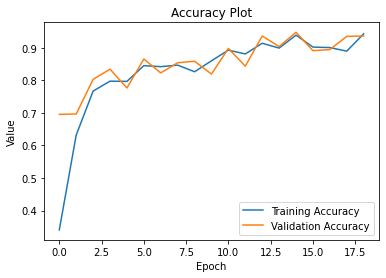

In [ ]:
    #accuracy train & validation
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Plot')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(loc="lower centre")
    plt.show()

# Pengujian Model

Saving blackrot2.JPG to blackrot2.JPG
blackrot2.JPG
[[0. 1. 0. 0.]]


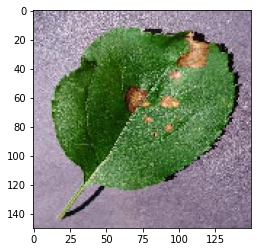

In [ ]:
    import numpy as np
    from google.colab import files
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    %matplotlib inline
     
    uploaded = files.upload()
     
    for fn in uploaded.keys():
     
      # predicting images
      path = fn
      img = image.load_img(path, target_size=(150,150))
      imgplot = plt.imshow(img)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
     
      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      
      print(fn)
      print(classes)
      # if classes[0,0,0,1]==1:
      #   print('Healthy')
      # elif classes[0,0,1,0]==1:
      #   print('Cedar Rust')
      # elif classes[0,1,0,0]==1:
      #   print('Black Rot')
      # elif classes[1,0,0,0]==1:
      #   print('Apple Scab')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
from keras import models

layer_outputs = [layer.output  for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

[[0. 0. 1. 0.]]


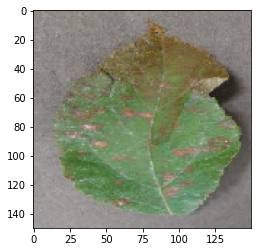

In [ ]:
img = image.load_img('AppleCedarRust4.JPG', target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
     
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 1. 0. 0.]]


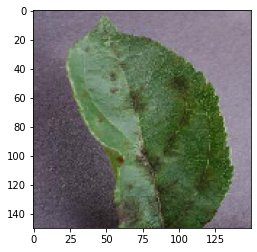

In [ ]:
img = image.load_img('AppleScab4.JPG', target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
     
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 0. 0. 1.]]


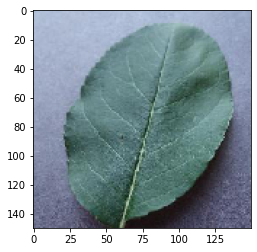

In [ ]:
img = image.load_img('Healthy1.JPG', target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
     
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 1. 0. 0.]]


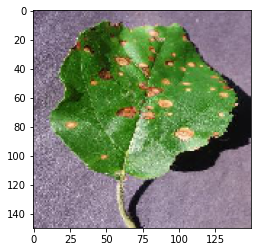

In [ ]:
img = image.load_img('Blackrot1.JPG', target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
     
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

# Pengecekan Hasil Ekstraksi Fitur
Memastikan fitur yang diekstraksi sudah sesuai dengan kebutuhan penelitian

In [ ]:
activations = activation_model.predict(images)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


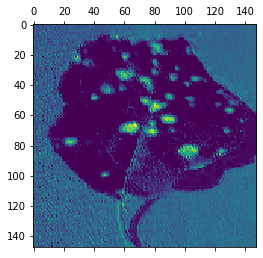

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

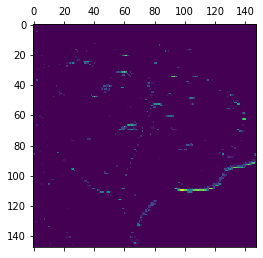

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

layer ke- 1


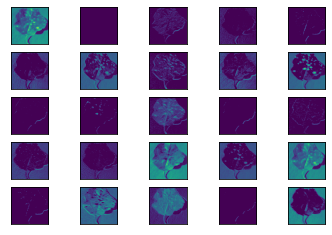

layer ke- 2


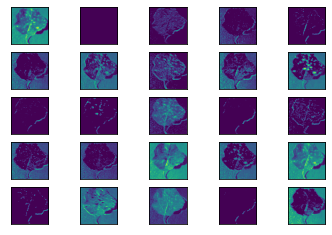

layer ke- 3


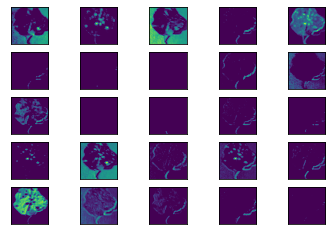

layer ke- 4


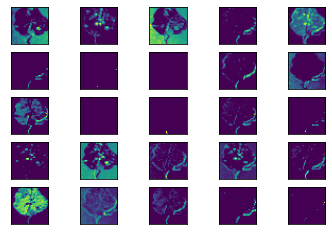

layer ke- 5


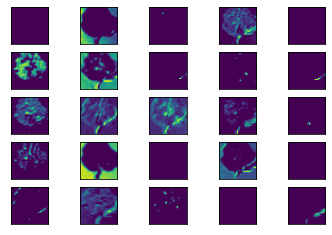

layer ke- 6


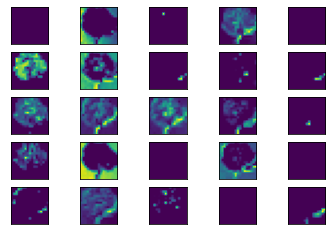

layer ke- 7


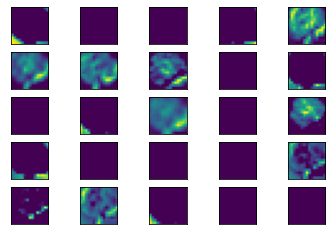

layer ke- 8


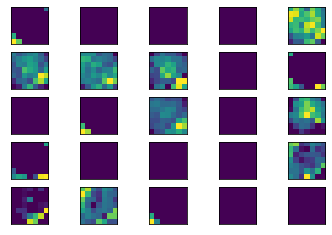

In [ ]:
square = 5
counter = 1
for fmap in activations:
  index = 1
  for _ in range(square):
	  for _ in range(square):
        
		  ax = plt.subplot(square, square, index)
		  ax.set_xticks([])
		  ax.set_yticks([])

		  plt.imshow(fmap[0, :, :, index-1], cmap='viridis')
		  index += 1
  
  print('layer ke-', counter)
  plt.show()
  counter += 1